In [1]:
!pip install -q transformers datasets rouge_score evaluate sentencepiece rouge

     |████████████████████████████████| 5.8 MB 9.4 MB/s 
     |████████████████████████████████| 451 kB 56.0 MB/s 
     |████████████████████████████████| 81 kB 2.0 MB/s 
     |████████████████████████████████| 1.3 MB 62.8 MB/s 
     |████████████████████████████████| 7.6 MB 67.6 MB/s 
     |████████████████████████████████| 182 kB 74.3 MB/s 
     |████████████████████████████████| 212 kB 67.2 MB/s 
     |████████████████████████████████| 132 kB 71.3 MB/s 
     |████████████████████████████████| 127 kB 66.6 MB/s 


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from datasets import load_dataset

In [3]:
from transformers import T5ForConditionalGeneration, AutoModelForCausalLM
from transformers import T5Tokenizer, AutoTokenizer

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
class SummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len

    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        ctext = "Text: " + self.data[index]['dialogue']
        ctext = ctext.replace('\n', '')

        text = "Summary: " +self.data[index]['summary']
        text = text.replace('\n', '')

        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, pad_to_max_length=True, truncation=True, return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,truncation=True ,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

In [6]:
def validate(tokenizer, model, loader):
    # model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            # input_ids = tokenizer(summarize_prompt, return_tensors="pt")["input_ids"]
            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_new_tokens=32,
                typical_p=0.5,
                do_sample=True,
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')
                print(preds, target, sep='\n')
            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [7]:
fine_tuned_model = '/content/drive/MyDrive/t5-base-fine-tuned'

In [ ]:
tokenizert5 = T5Tokenizer.from_pretrained('t5-base')
modelt5 = T5ForConditionalGeneration.from_pretrained(fine_tuned_model)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [9]:
import pandas as pd

Compare summarization metrics on validation dataset (knkarthick/dialogsum) for fine-tuned flant5-base and gpt neo (EleutherAI/gpt-neo-125M)

In [10]:
val_df = pd.read_csv('/content/drive/MyDrive/t5-base-fine-tuned/summary_predictions.csv')  # t5-base predictions
val_gpt_df = pd.read_csv('/content/drive/MyDrive/t5-base-fine-tuned/summary_predictions_gpt.csv')  # gpt neo predictions

In [ ]:
val_df.iloc[500]['Generated Text']

"Person2# tells #Person1# they're going to Salt Lake City for a vacation. They'll spend the nights in hotels and enjoy local food as they pass by."

In [12]:
val_gpt_df.iloc[500]['Generated Text']

" When you finish the book about the coming holidays, you'll learn the name of your favorite actor and why he is the most popular person in Hollywood. These lessons will also help"

In [30]:
from rouge import Rouge

In [31]:
rouge=Rouge()

In [33]:
print(rouge.get_scores(val_df["Generated Text"], val_df["Actual Text"], avg=True))
print(rouge.get_scores(val_gpt_df["Generated Text"].astype(str), val_df["Actual Text"], avg=True))

{'rouge-1': {'r': 0.43205928398147153, 'p': 0.35916915893309737, 'f': 0.381445206974748}, 'rouge-2': {'r': 0.16086325183140138, 'p': 0.14055691503625395, 'f': 0.1447594913437513}, 'rouge-l': {'r': 0.39100024704050346, 'p': 0.3262211749771986, 'f': 0.34579111103269633}}
{'rouge-1': {'r': 0.1379110995726532, 'p': 0.09565017075926081, 'f': 0.10838872149707485}, 'rouge-2': {'r': 0.010459176280370772, 'p': 0.007022231843104133, 'f': 0.008059251607527034}, 'rouge-l': {'r': 0.12278807095142087, 'p': 0.08515847021584338, 'f': 0.09646686498082306}}


In [20]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [25]:
val_df['BLEU'] = val_df.apply(lambda row: sentence_bleu([row["Actual Text"]],str(row["Generated Text"]), smoothing_function=SmoothingFunction(epsilon=1e-12).method1), axis=1)

In [26]:
val_gpt_df['BLEU'] = val_gpt_df.apply(lambda row: sentence_bleu([row["Actual Text"]],str(row["Generated Text"]), smoothing_function=SmoothingFunction(epsilon=1e-12).method1), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f919d1278b0>]],
      dtype=object)

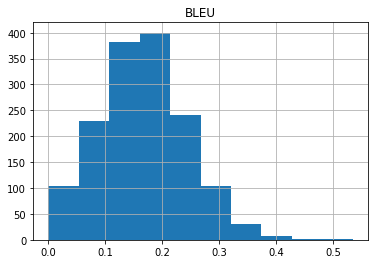

In [27]:
val_gpt_df.hist(column='BLEU')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f919cbb8070>]],
      dtype=object)

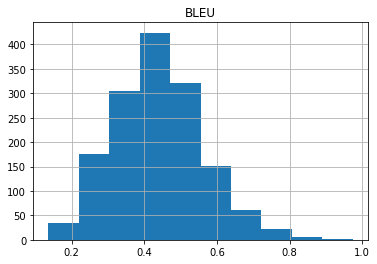

In [28]:
val_df.hist(column='BLEU')

In [ ]:
val_df['BLEU'].mean()

0.4395000888470286

In [34]:
val_gpt_df['BLEU'].mean()

0.16484554204251115